# Use of PSF CDP to determine point source centroid

In [1]:
# load modules
import funcs
import mrsobs
from distortionMaps import d2cMapping

import os
import numpy as np
from astropy.io import fits
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# Define the paths to the data
workDir = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir  = workDir+'cdp_data/'
d2cMapDir = workDir+'notebooks/distortionMaps/'

In [3]:
# Pick spectral band (side of the slope image) to be analyzed
band = '1A'

In [4]:
# load the MRS distortion maps, they are used extensively in a multitude of python functions relating to the analysis of MRS data
d2cMaps = d2cMapping(band,cdpDir+'CDP8/',fileversion = "8B.05.00") # here, d2c stands for detector to cube transformation, from x,y integer pixel coordinates, to alpha, beta (or RA and DEC), and wavelength coordinates

In [5]:
print('DISTORTION CDP filename: {}'.format(d2cMaps['cdp_filename']))

DISTORTION CDP filename: MIRI_FM_MIRIFUSHORT_12SHORT_DISTORTION_8B.05.00.fits


In [6]:
# spectral gridding
specres_table = funcs.get_cdps(cdpDir=cdpDir,band=band)[4]
# Let's construct the spectral grid for the specified MRS band
lambcens,lambfwhms = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table)

In [7]:
print '{} spectral bins'.format(len(lambcens))

598 spectral bins


In [8]:
psf_fits_file = fits.open(cdpDir+"MIRI_FM_MIRIFUSHORT_1SHORT_PSF_07.02.00.fits")

In [9]:
campaign = 'CV2'
lvl2path = workDir+'{}_data/LVL2/'.format(campaign)

pointing = 'P1'
position = 'middle' # only applicable to FM raster scan observations

if campaign in ['CV2','CV3']:
    point_source_sci,point_source_bkg = mrsobs.CV_800K_BB_MRS_OPT_02_obs(lvl2path,band,campaign=campaign,pointing=pointing,output='img')
elif campaign == 'FM':
    point_source_sci,point_source_bkg = mrsobs.FM_MTS_800K_BB_MRS_OPT_06_raster(lvl2path,position=position,pointing=pointing)
#     point_source_sci,point_source_bkg = mrsobs.FM_MTS_800K_BB_MRS_RAD_06_raster(lvl2path,band)
#     point_source_sci,point_source_bkg = mrsobs.FM_MTS_800K_BB_MRS_OPT_01_raster(lvl2path,pointing='P18')

In [11]:
point_source_bkgsubtr = point_source_sci-point_source_bkg
point_source_oddevencorr = funcs.OddEvenRowSignalCorrection(point_source_bkgsubtr)
point_source_oddevencorr[point_source_oddevencorr<0] = 0

ibin = 200
ij = (np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)

# test_img = np.zeros((1024,1032))
# test_img[512,:516] = 1
# ij = ((d2cMaps['sliceMap'] !=0) & (test_img==1))

In [15]:
def evaluate_psf_cdp(psffits,d2cMaps,ij,source_center=[0,0]):
    # PSF CDP is provided as a spectral cube
    #>get values
    psf_values = psffits[1].data.transpose(2,1,0) # flip data from Z,Y,X to X,Y,Z

    # #>normalize values
    # for layer in range(psf_values.shape[2]):
    #     psf_values[:,:,layer] /= psf_values[:,:,layer].sum()

    #>get grid
    NAXIS1,NAXIS2,NAXIS3 = psf_values.shape

    alphastpix = psffits[1].header['CRPIX1'] # pixel nr
    alpha_step = psffits[1].header['CDELT1'] # arcsec/pix
    stalpha    = psffits[1].header['CRVAL1']-(alphastpix-1)*alpha_step # arcsec

    betastpix = psffits[1].header['CRPIX2'] # pixel nr
    beta_step = psffits[1].header['CDELT2'] # arcsec/pix
    stbeta    = psffits[1].header['CRVAL2']-(betastpix-1)*beta_step # arcsec

    stwavl = psffits[1].header['CRVAL3'] # microns
    wavl_step   = psffits[1].header['CDELT3'] # microns/pix

    alpha_slices = np.linspace(stalpha,stalpha+ (NAXIS1-1.5)*alpha_step,NAXIS1)
    beta_slices  = np.linspace(stbeta,stbeta+ (NAXIS2-1.5)*beta_step,NAXIS2)
    wvl_slices   = np.linspace(stwavl ,stwavl+NAXIS3*wavl_step,NAXIS3)

    #> center psf to source
    alpha_slices += source_center[0]
    beta_slices  += source_center[1]

    #> create interpolant based on regular grid
    interpolpsf = RegularGridInterpolator((alpha_slices,beta_slices,wvl_slices),psf_values)
    interpolpsf.fill_value=0.
    interpolpsf.bounds_error=False

    # evaluate psf at each pixel center and pixel corner
    alphaULMap = d2cMaps['alphaULMap'][ij]
    alphaURMap = d2cMaps['alphaURMap'][ij]
    alphaLLMap = d2cMaps['alphaLLMap'][ij]
    alphaLRMap = d2cMaps['alphaLRMap'][ij]
    alphaMap   = d2cMaps['alphaMap'][ij]

    betaULMap = d2cMaps['betaULMap'][ij]
    betaURMap = d2cMaps['betaURMap'][ij]
    betaLLMap = d2cMaps['betaLLMap'][ij]
    betaLRMap = d2cMaps['betaLRMap'][ij]
    betaMap   = d2cMaps['betaMap'][ij]

    lambdaULMap = d2cMaps['lambdaULMap'][ij]
    lambdaURMap = d2cMaps['lambdaURMap'][ij]
    lambdaLLMap = d2cMaps['lambdaLLMap'][ij]
    lambdaLRMap = d2cMaps['lambdaLRMap'][ij]
    lambdaMap = d2cMaps['lambdaMap'][ij]

    #> interpolate psf to science image pixel centers and corners
    #-- assume no significant change in wavelength over one pixel size
    psfUL  = interpolpsf((alphaULMap,betaULMap,lambdaULMap))
    psfUR  = interpolpsf((alphaURMap,betaURMap,lambdaURMap))
    psfLL  = interpolpsf((alphaLLMap,betaLLMap,lambdaLLMap))
    psfLR  = interpolpsf((alphaLRMap,betaLRMap,lambdaLRMap))
    psfCEN = interpolpsf((alphaMap,betaMap,lambdaMap))

    #> evaluate psf as a weighted average
    w = np.array([0.125,0.125,0.125,0.125,0.5]) # WARNING: ARBITRARY!
    sumweights = w.sum()
    
    psf = np.zeros((1024,1032))
    psf[ij] = (w[0]*psfUL+w[1]*psfUR+w[2]*psfLL+w[3]*psfLR+w[4]*psfCEN)/sumweights

    return psf

In [16]:
psf = evaluate_psf_cdp(psf_fits_file,d2cMaps,ij,source_center=[0,0])

<IPython.core.display.Javascript object>


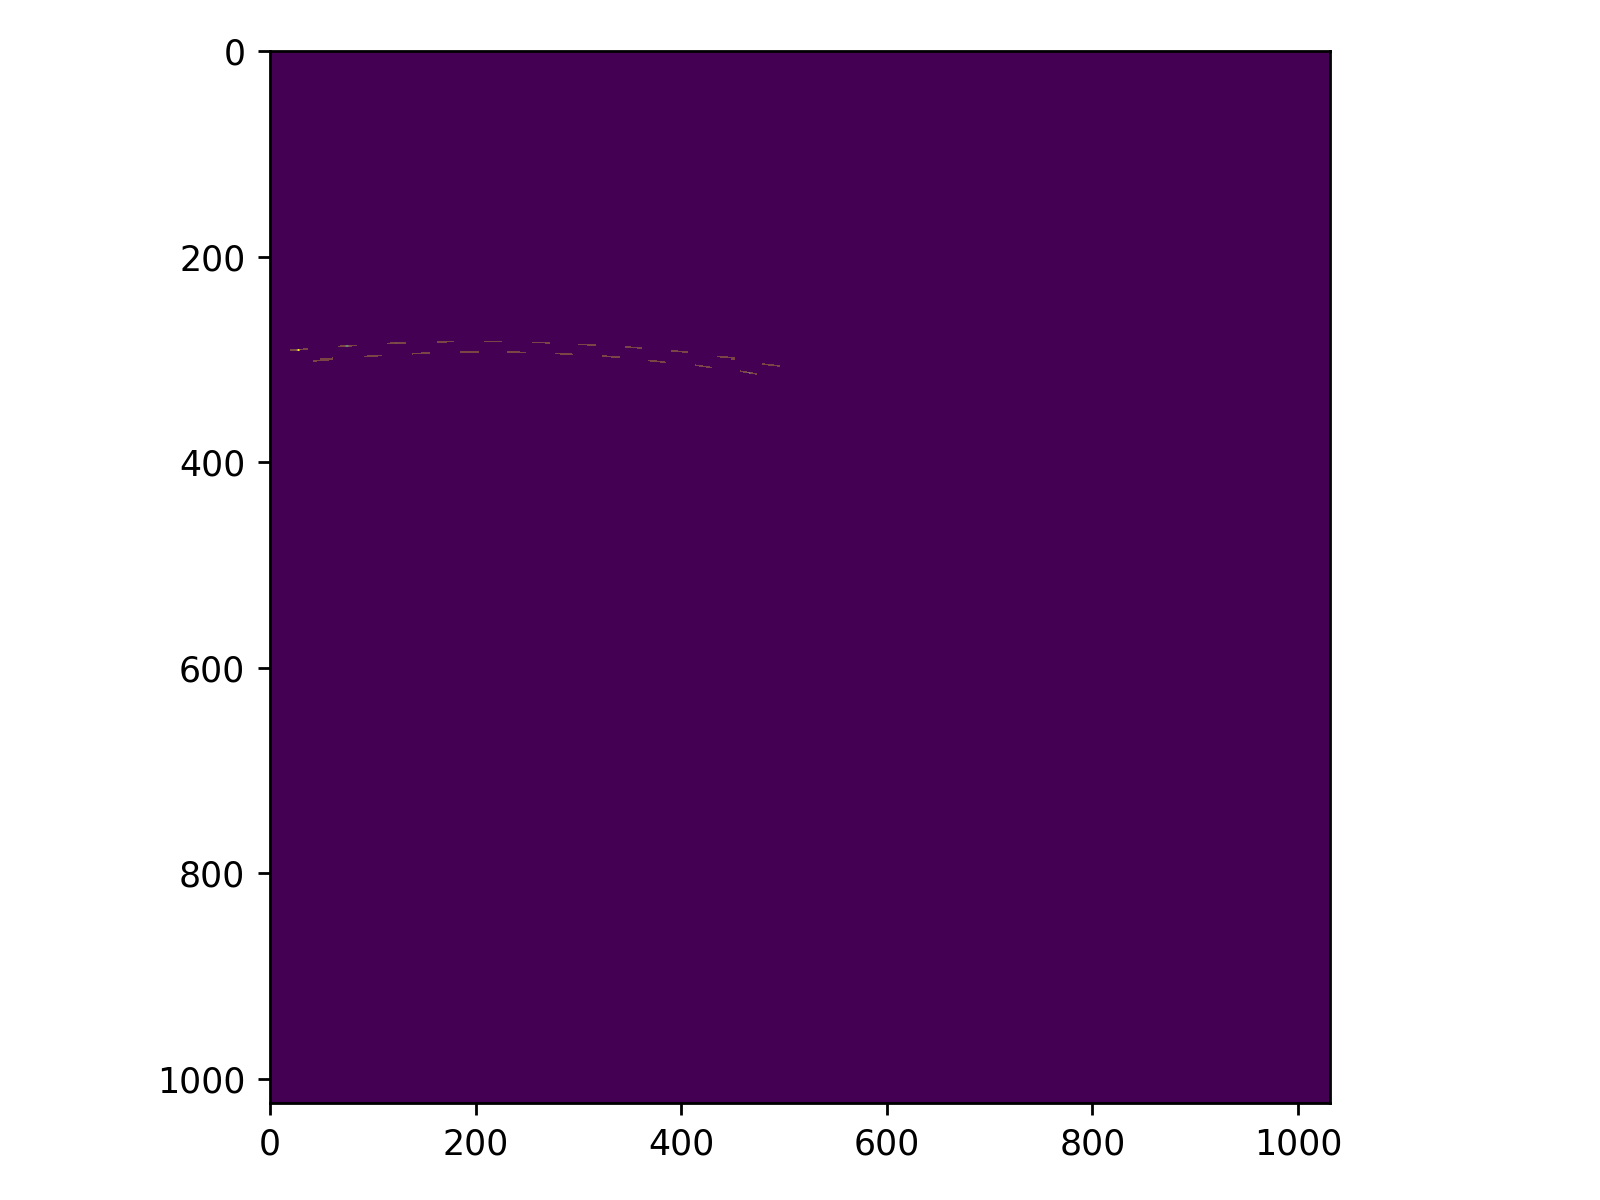

In [17]:
test_img = np.zeros(psf.shape)
test_img[ij] = 1
plt.close('all')
plt.figure()
plt.imshow(psf*100.)
plt.imshow(test_img,alpha=0.3)
plt.tight_layout()

In [18]:
def psf_min_function(pin, A0, a0, b0):
    psffits, d2cMaps, ij = pin
    model = evaluate_psf_cdp(psffits, d2cMaps, ij, source_center=[a0,b0])
    model *= A0/np.max(model)
    return model[ij]

test_img = point_source_oddevencorr.copy()
test_img[np.isnan(test_img)] = 0

x0 = np.argmax(test_img[ij])
A0 = test_img[ij][x0]
a0 = d2cMaps["alphaMap"][ij][x0]
b0 = d2cMaps["betaMap"][ij][x0]

print 'Zeroth order centroid estimate:'
print 'Amplitude: {} DN/sec'.format(round(A0,3))
print 'Along-slice peak position: {} arcsec'.format(round(a0,3))
print 'Across-slice peak position: {} arcsec'.format(round(b0,3))
print ''

popt, pcov = curve_fit(psf_min_function, (psf_fits_file, d2cMaps, ij),
                       test_img[ij], p0=[A0,a0,b0])

print 'PSF-fitted centroid:'
print 'Amplitude: {} DN/sec'.format(round(popt[0],3))
print 'Along-slice peak position: {} arcsec'.format(round(popt[1],3))
print 'Across-slice peak position: {} arcsec'.format(round(popt[2],3))

Zeroth order centroid estimate:
Amplitude: 17.486 DN/sec
Along-slice peak position: -1.248 arcsec
Across-slice peak position: -0.354 arcsec

PSF-fitted centroid:
Amplitude: 15.64 DN/sec
Along-slice peak position: -1.125 arcsec
Across-slice peak position: -0.345 arcsec


In [19]:
model = evaluate_psf_cdp(psf_fits_file, d2cMaps, ij, source_center=[popt[1],popt[2]])
model *= A0/np.max(model)

<IPython.core.display.Javascript object>


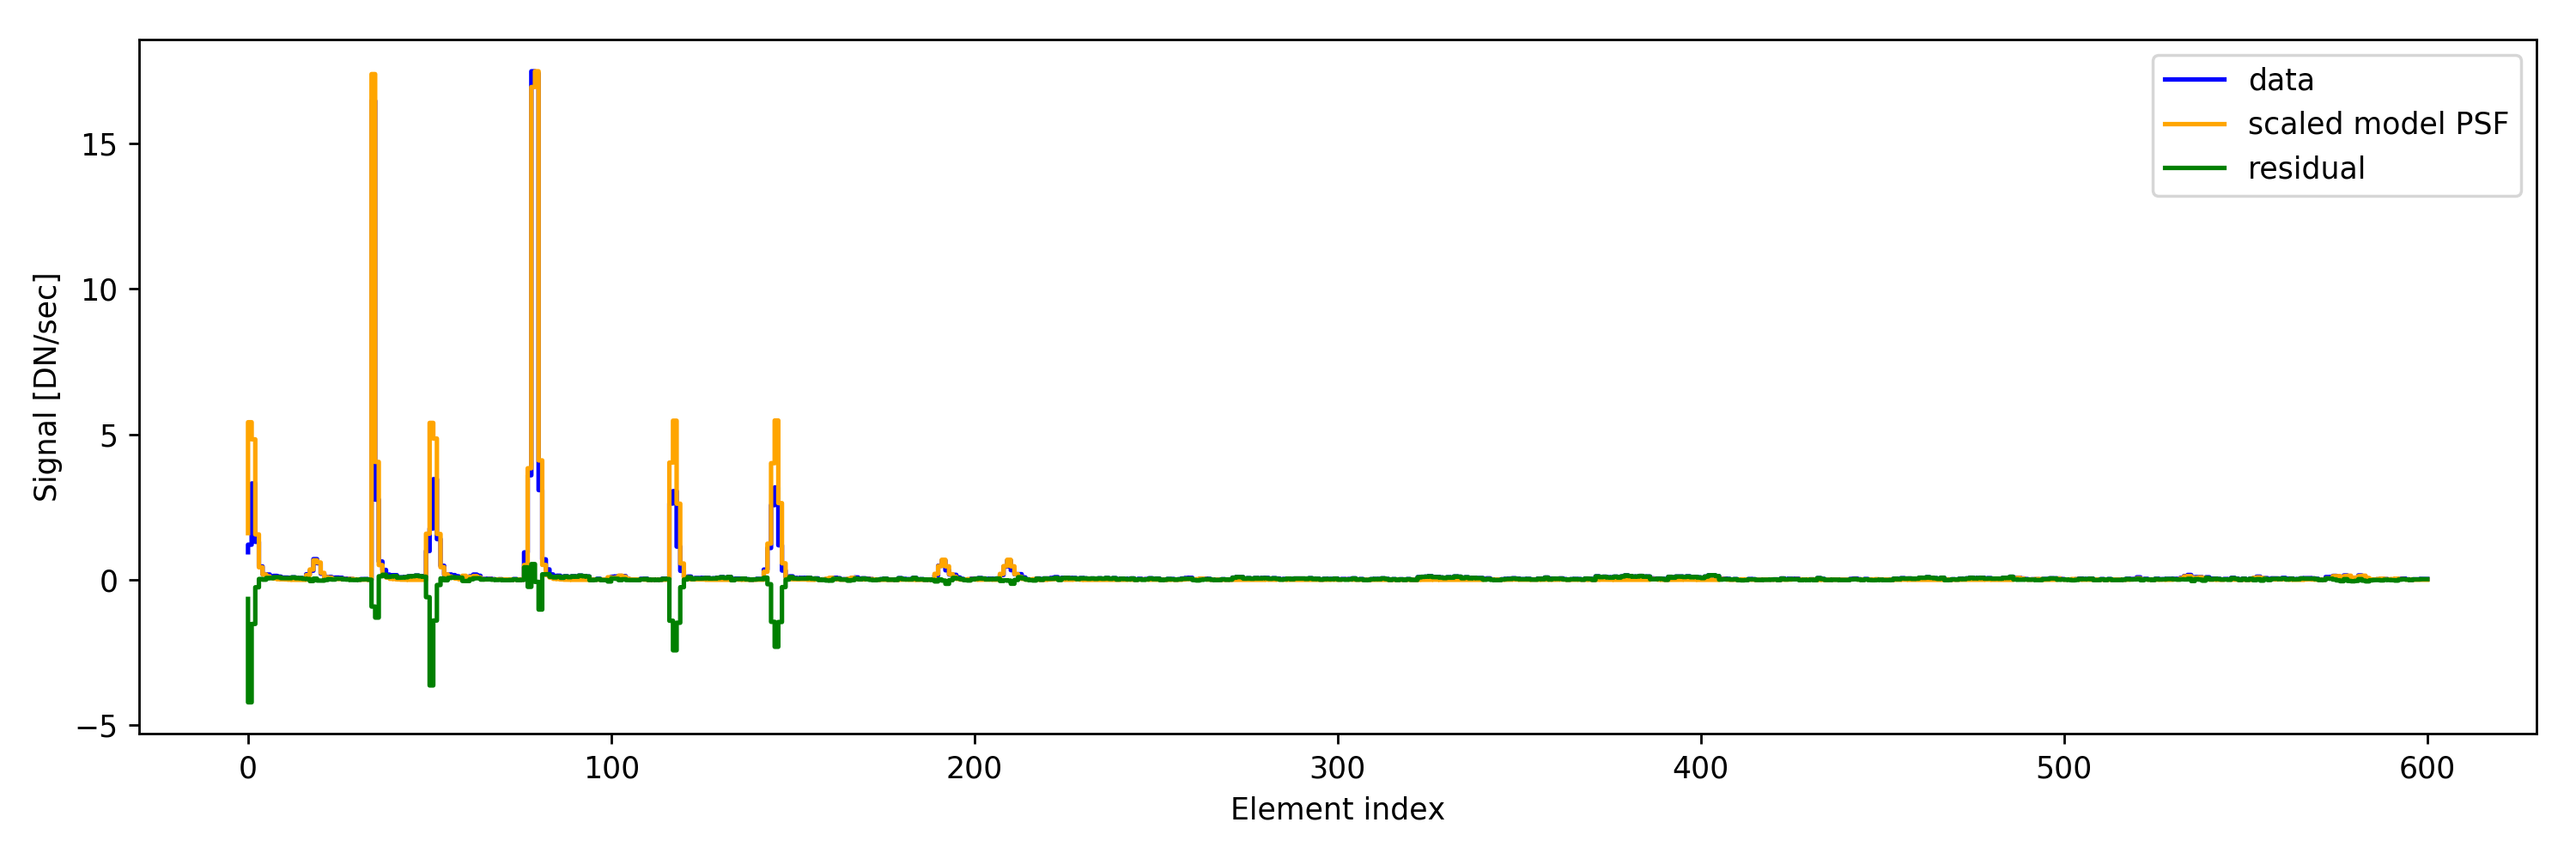

In [20]:
plt.figure(figsize=(12,4))
plt.step(point_source_oddevencorr[ij],'b',label='data')
plt.step(model[ij],'orange',label='scaled model PSF')
plt.step(point_source_oddevencorr[ij]-model[ij],'g',label='residual')
plt.xlabel('Element index')
plt.ylabel('Signal [DN/sec]')
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


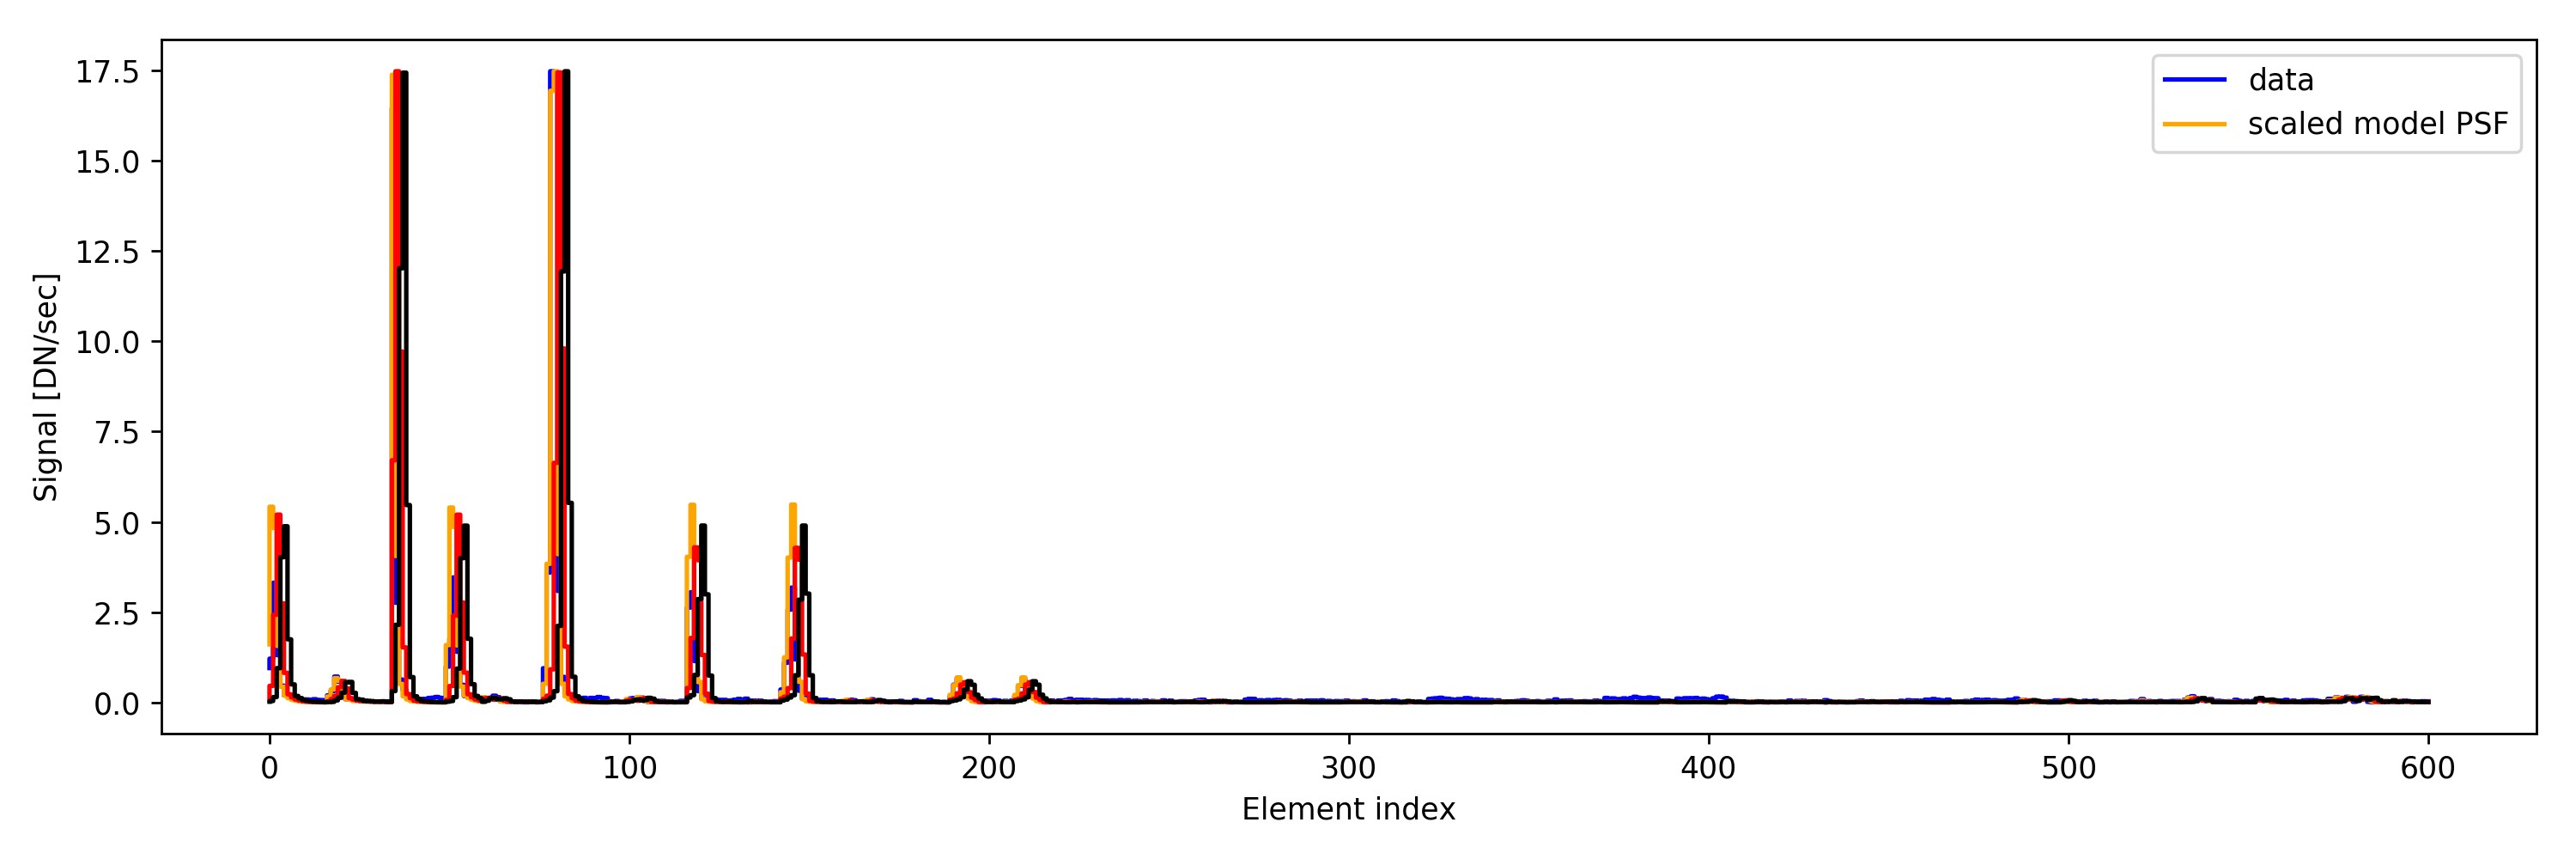

In [21]:
model = evaluate_psf_cdp(psf_fits_file, d2cMaps, ij, source_center=[popt[1],popt[2]])
model *= A0/np.max(model)

model2 = evaluate_psf_cdp(psf_fits_file, d2cMaps, ij, source_center=[popt[1]+0.3,popt[2]])
model2 *= A0/np.max(model2)

model3 = evaluate_psf_cdp(psf_fits_file, d2cMaps, ij, source_center=[popt[1]+0.6,popt[2]])
model3 *= A0/np.max(model3)

plt.figure(figsize=(12,4))
plt.step(point_source_oddevencorr[ij],'b',label='data')
plt.step(model[ij],'orange',label='scaled model PSF')
plt.step(model2[ij],'r')
plt.step(model3[ij],'k')
plt.xlabel('Element index')
plt.ylabel('Signal [DN/sec]')
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


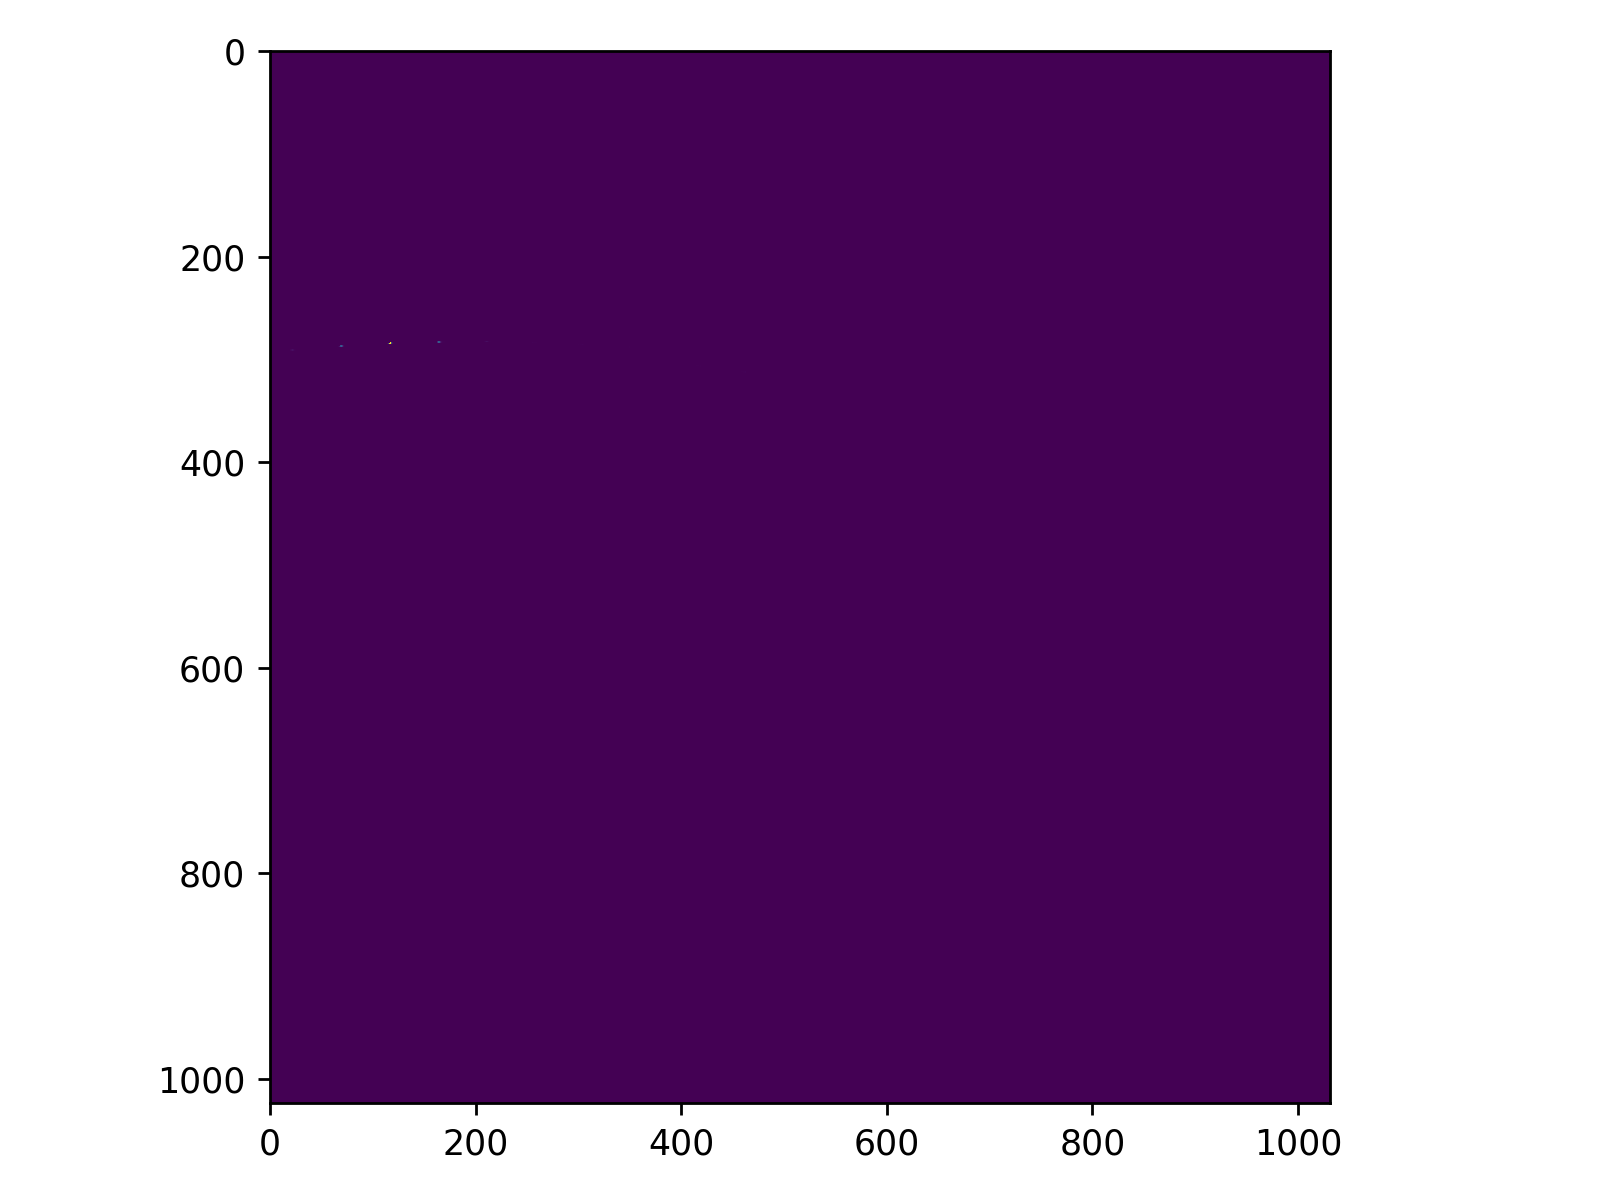

<IPython.core.display.Javascript object>


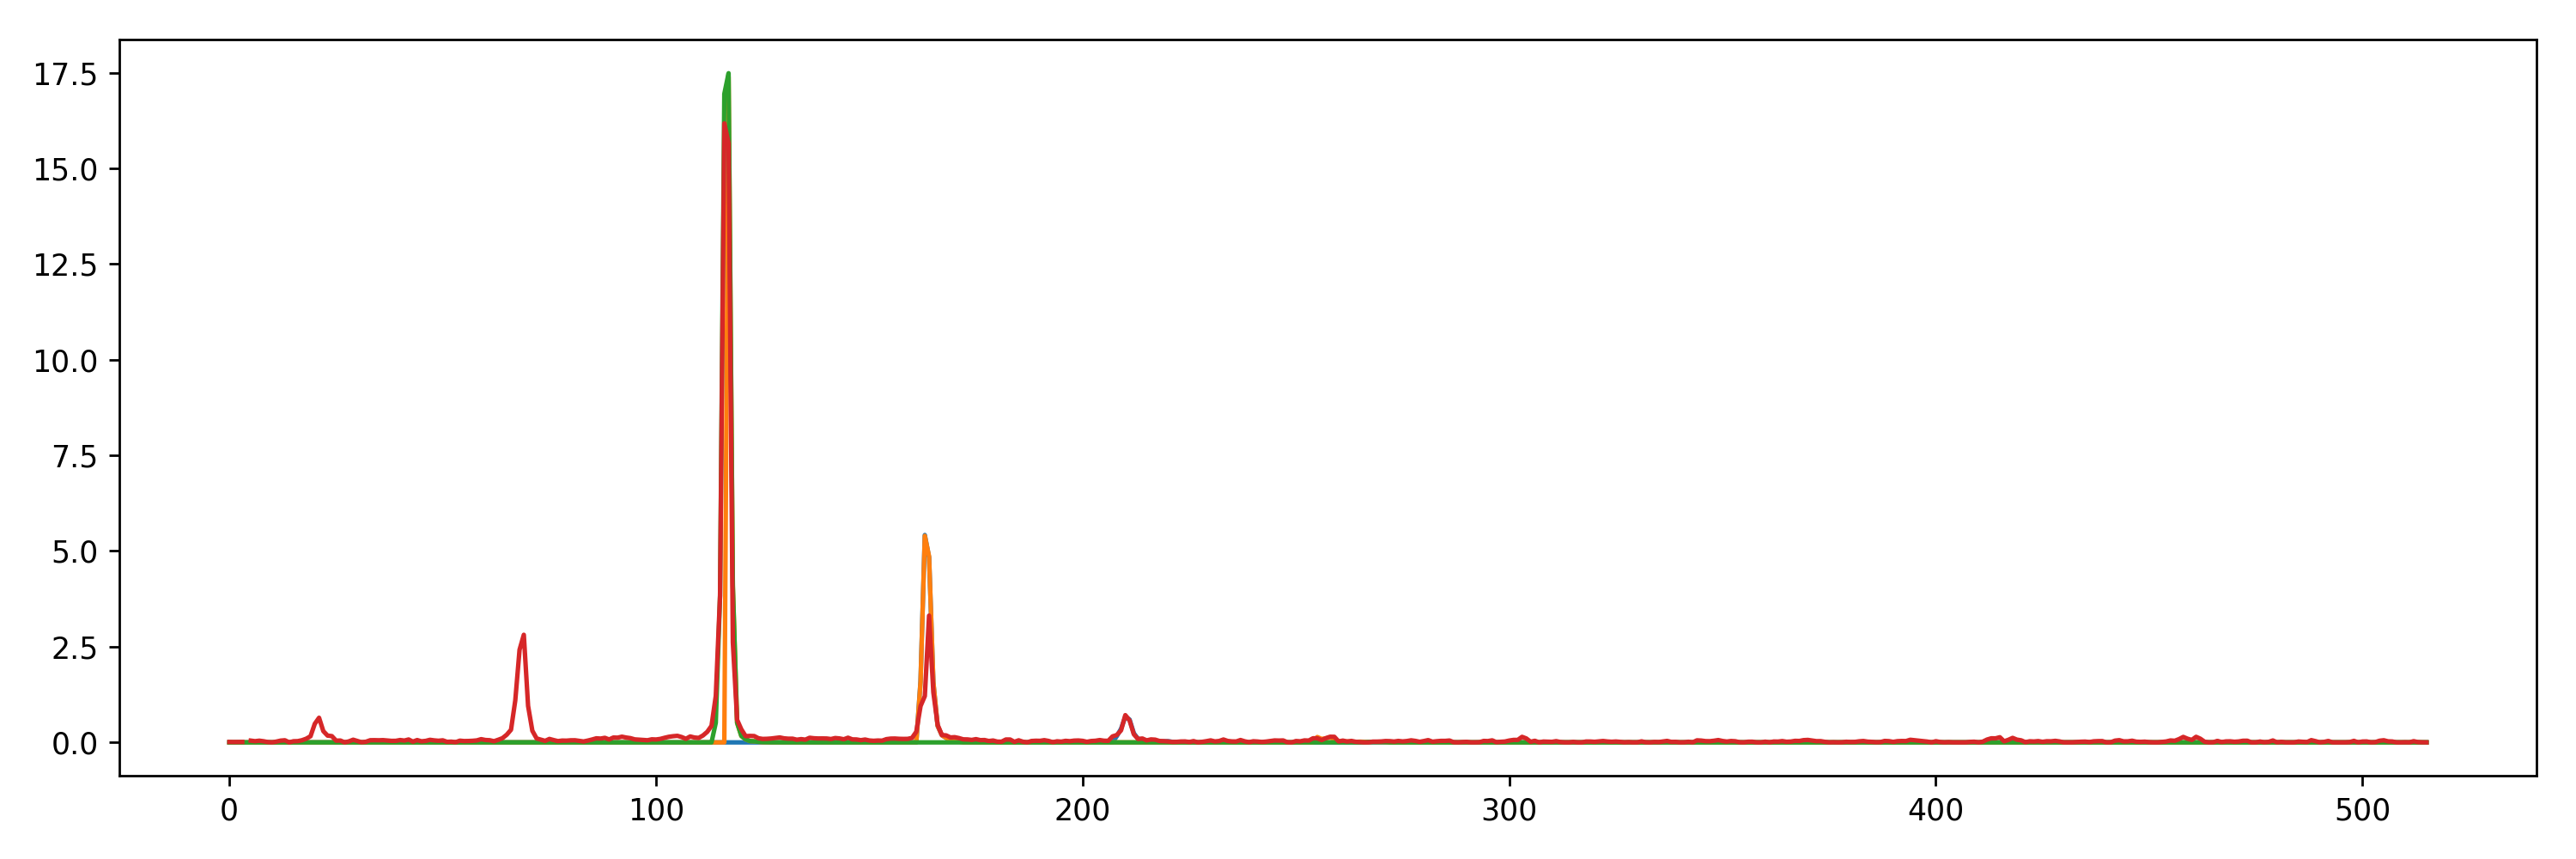

In [22]:
plt.figure()
plt.imshow(model)
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.plot(model[283,:516])
plt.plot(model[284,:516])
plt.plot(model[285,:516])
plt.plot(point_source_oddevencorr[283,:516])
plt.tight_layout()

### All spectral bins

In [ ]:
amp,alphacen,betacen = [np.zeros(len(lambcens)) for i in range(3)]
for ibin in range(len(lambcens)):
    if ibin%50 == 0:
        print 'Bin {}'.format(ibin)
    ij = (np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)

    x0 = np.argmax(test_img[ij])
    A0 = test_img[ij][x0]
    a0 = d2cMaps["alphaMap"][ij][x0]
    b0 = d2cMaps["betaMap"][ij][x0]

    popt, pcov = curve_fit(psf_min_function, (psf_fits_file, d2cMaps, ij),
                           test_img[ij], p0=[A0,a0,b0])
    
    amp[ibin],alphacen[ibin],betacen[ibin] = popt[0],popt[1],popt[2]

<IPython.core.display.Javascript object>


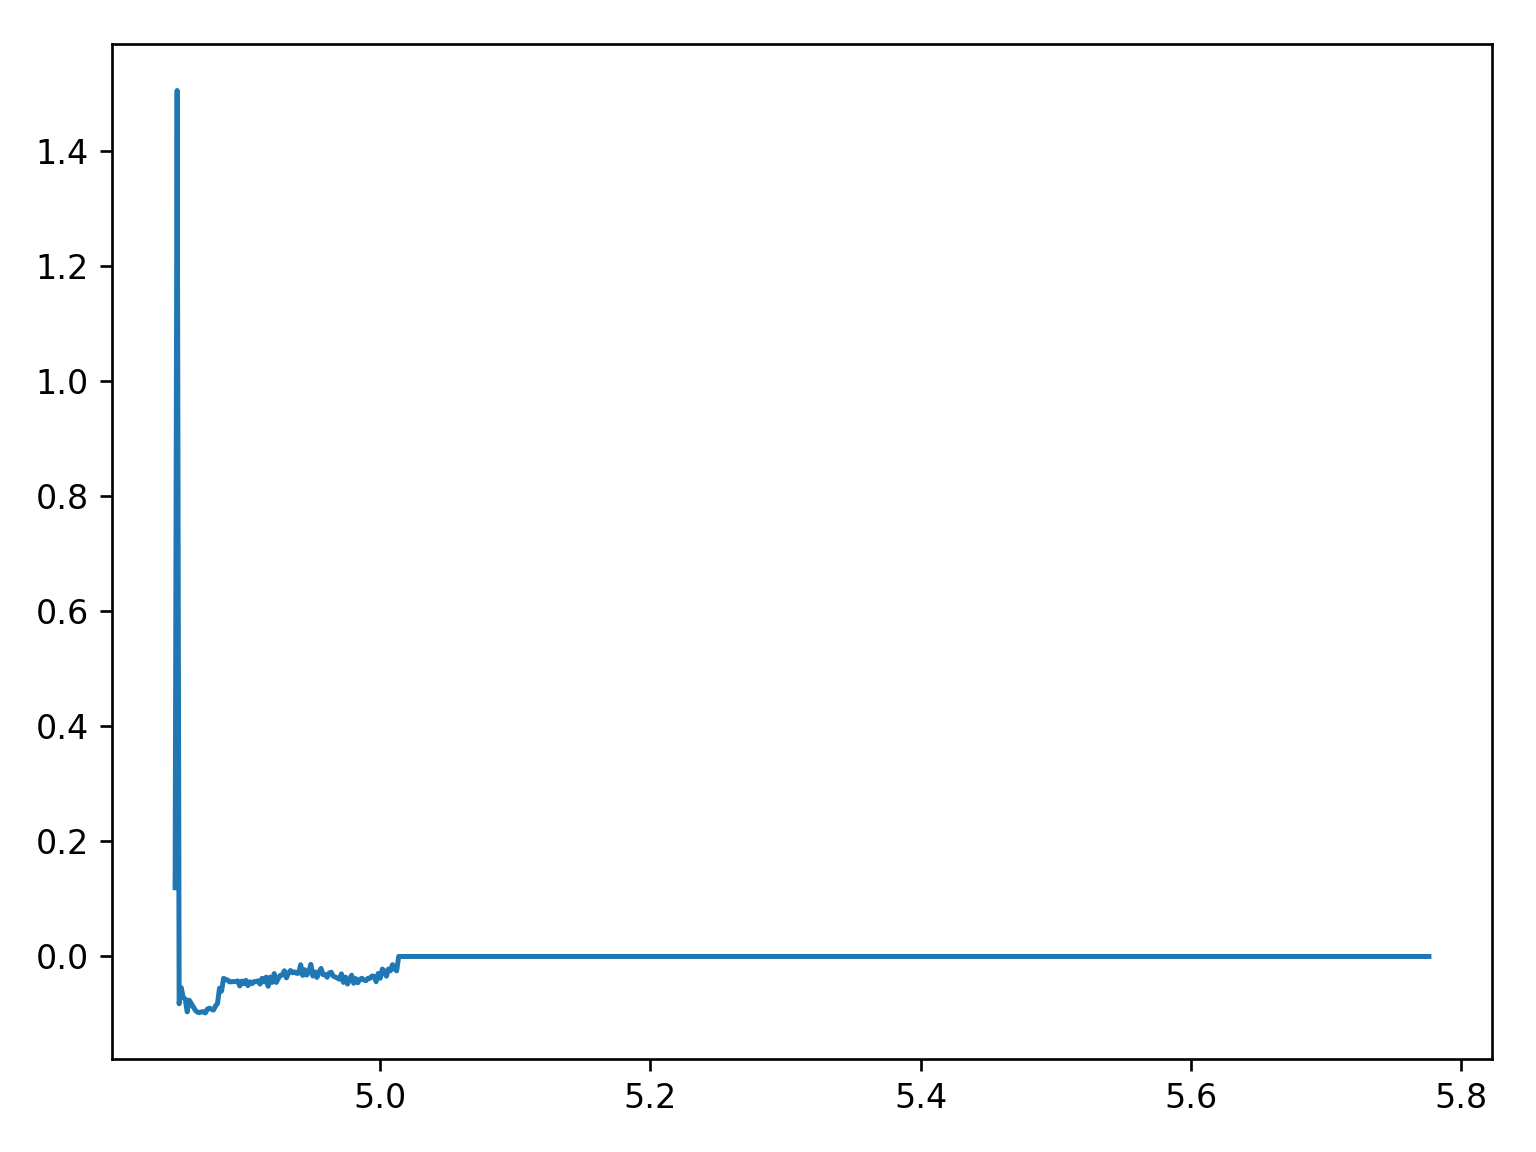

In [55]:
plt.figure()
plt.plot(lambcens,alphacen)
plt.tight_layout()

### All CV3 pointings

In [28]:
campaign = 'CV2'
lvl2path = workDir+'{}_data/LVL2/'.format(campaign)
ibin = len(lambcens)/2
# amp,alphacen,betacen = {},{},{}
for pointing in range(17):
    if campaign == 'CV2':
        pointing = 'P'+str(pointing)
    elif campaign == 'CV3':
        pointing = 'Q'+str(pointing)
    print pointing
    point_source_sci,point_source_bkg = mrsobs.CV_800K_BB_MRS_OPT_02_obs(lvl2path,band,campaign=campaign,pointing=pointing,output='img')
    point_source_bkgsubtr = point_source_sci-point_source_bkg
    point_source_oddevencorr = funcs.OddEvenRowSignalCorrection(point_source_bkgsubtr)
    
    ij = (np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)
    
    test_img = point_source_oddevencorr.copy()
    test_img[np.isnan(test_img)] = 0

    x0 = np.argmax(test_img[ij])
    A0 = test_img[ij][x0]
    a0 = d2cMaps["alphaMap"][ij][x0]
    b0 = d2cMaps["betaMap"][ij][x0]

    popt, pcov = curve_fit(psf_min_function, (psf_fits_file, d2cMaps, ij),
                           test_img[ij], p0=[A0,a0,b0])
    
    amp[pointing],alphacen[pointing],betacen[pointing] = popt[0],popt[1],popt[2]
    

P0
P1
P2
P3
P4
P5
P6
P7
P8
P9
P10
P11
P12
P13
P14
P15
P16


0.177210143797 -1.77210143797


<IPython.core.display.Javascript object>


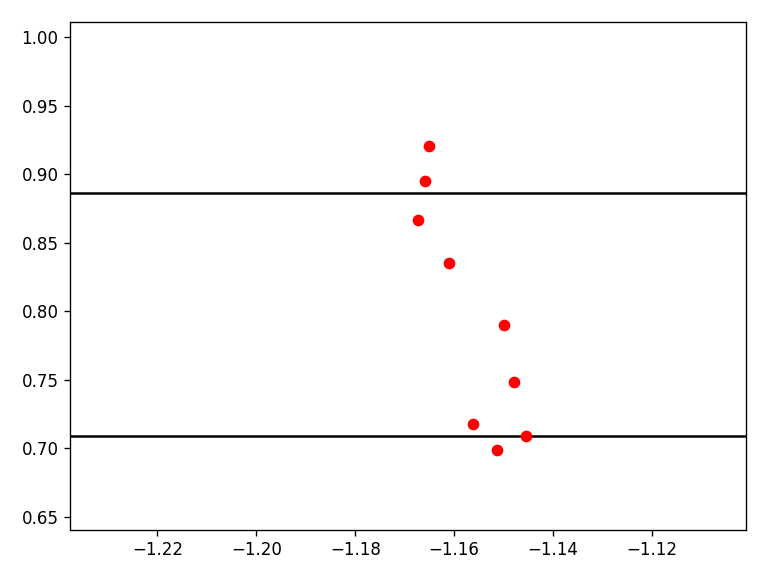

In [36]:
d2c_fits_file = cdpDir+"CDP8/MIRI_FM_MIRIFUSHORT_12SHORT_DISTORTION_8B.05.01.fits"
dist = fits.open(d2c_fits_file)
bdel = dist[0].header['B_DEL{}'.format(band[0])]
bzero = dist[0].header['B_ZERO{}'.format(band[0])]
print bdel,bzero

betas = bzero+np.arange(-1,21)*bdel

plt.figure()
for pointing_nr in range(17):
    pointing = 'P'+str(pointing_nr)
    plt.plot(alphacen[pointing],betacen[pointing],'ko')
    pointing = 'Q'+str(pointing_nr)
    plt.plot(alphacen[pointing],betacen[pointing],'ro')
plt.hlines(betas,-1.377,1.37,'k')
plt.xlim(-1.377,1.37)
plt.ylim(-1.377,1.37)
plt.tight_layout()